# Policy gradient methods in PyTorch

## Table of contents

1. [Understanding policy gradient methods](#understanding-policy-gradient-methods)
2. [Setting up the environment](#setting-up-the-environment)
3. [Defining the environment for training](#defining-the-environment-for-training)
4. [Building the policy network](#building-the-policy-network)
5. [Implementing the action selection policy](#implementing-the-action-selection-policy)
6. [Computing the policy gradient](#computing-the-policy-gradient)
7. [Implementing the REINFORCE algorithm](#implementing-the-reinforce-algorithm)
8. [Training the policy gradient agent](#training-the-policy-gradient-agent)
9. [Evaluating the policy gradient agent](#evaluating-the-policy-gradient-agent)
10. [Experimenting with hyperparameters](#experimenting-with-hyperparameters)

## Understanding policy gradient methods


### **Key concepts**
Policy gradient methods are a class of reinforcement learning algorithms that directly optimize the policy (a mapping from states to actions) by maximizing the expected cumulative reward. Unlike value-based methods like Q-learning, which focus on estimating action-value functions, policy gradient approaches operate in the space of policies, allowing them to handle continuous action spaces and stochastic policies effectively.

Key elements of policy gradient methods include:
- **Policy Representation**: A neural network parameterized by weights, used to model the policy.
- **Objective Function**: The policy is optimized to maximize the expected reward, often using the REINFORCE algorithm or its variants.
- **Gradient Estimation**: The policy gradient theorem provides a mathematical framework to compute gradients of the expected reward with respect to policy parameters.
- **Stochastic Policy**: Enables probabilistic action selection, making exploration an inherent part of the algorithm.

Policy gradient methods are particularly effective in environments where continuous or probabilistic actions are required.

### **Applications**
Policy gradient methods are widely used in reinforcement learning tasks, such as:
- **Robotics**: Enabling robots to learn control tasks like grasping, walking, or balancing.
- **Game AI**: Training agents to play games like Go or Poker, where strategic exploration is essential.
- **Autonomous systems**: Applications in self-driving cars, UAV navigation, and industrial automation.
- **Simulations**: Optimizing policies in physical simulations, such as controlling energy systems or fluid dynamics.

### **Advantages**
- **Continuous action spaces**: Handles tasks with continuous actions, unlike discrete-only methods like Q-learning.
- **Exploration through stochastic policies**: Ensures diverse action exploration during training.
- **Direct optimization of the policy**: Does not require a value function, simplifying implementation in certain tasks.
- **Flexibility**: Works well in environments with complex dynamics and state-action mappings.

### **Challenges**
- **High variance in gradients**: Policy gradients can suffer from high variance, leading to unstable training.
- **Sample inefficiency**: Requires large amounts of interaction data to achieve convergence.
- **Hyperparameter sensitivity**: Performance depends heavily on careful tuning of learning rates and reward scaling.
- **Local optima**: Optimization may converge to suboptimal solutions, especially in complex environments.

## Setting up the environment


##### **Q1: How do you install the necessary libraries for implementing policy gradient methods in PyTorch?**


In [19]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install gymnasium
# !pip install numpy matplotlib seaborn

##### **Q2: How do you import the required modules for building the policy network and interacting with the environment in PyTorch?**


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

##### **Q3: How do you configure the environment to utilize a GPU for training policy gradient agents in PyTorch?**

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Defining the environment for training


##### **Q4: How do you load a reinforcement learning environment using OpenAI Gym for training a policy gradient agent?**


In [22]:
env = gym.make('CartPole-v1')
print(env)

<TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>


##### **Q5: How do you retrieve the state and action space of the Gym environment for defining the policy network input and output?**


In [23]:
state_dim = env.observation_space.shape[0]  # number of input features
action_dim = env.action_space.n  # number of possible action
print(state_dim)
print(action_dim)

4
2


##### **Q6: How do you reset the environment and retrieve the initial state for the training episodes?**

In [24]:
state, _ = env.reset()
state = torch.tensor(state, dtype=torch.float32).to(device)
print(state)

tensor([-0.0012, -0.0196, -0.0198, -0.0311], device='cuda:0')


## Building the policy network


##### **Q7: How do you define the architecture of the policy network using `torch.nn.Module`?**


In [25]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, action_dim)

##### **Q8: How do you implement the forward pass of the policy network to output action probabilities for a given state?**


In [26]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=-1)  # output action probabilities
        return x

##### **Q9: How do you initialize the weights of the policy network to ensure stable training and faster convergence?**

In [27]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=-1)  # output action probabilities
        return x

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

## Implementing the action selection policy


##### **Q10: How do you implement an action selection mechanism by sampling from the policy network’s output?**


In [28]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=-1)  # output action probabilities
        return x

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
        
    def select_action(self, state):
        probs = self.forward(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob

##### **Q11: How do you store the log-probabilities of the selected actions to be used later in computing the policy gradient?**


In [29]:
log_probs = []
rewards = []

##### **Q12: How do you modify the action selection process for continuous action spaces using different probability distributions ?**

In [30]:
# for discrete, using Categorical; for continuous, use Normal distribution
# example (won't be used for CartPole)
# dist = torch.distributions.Normal(mean, std)
# action = dist.sample()
# log_prob = dist.log_prob(action).sum()

## Computing the policy gradient


##### **Q13: How do you compute the reward-to-go (discounted sum of future rewards) for each action in an episode?**


In [31]:
def compute_returns(rewards, gamma):
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns, dtype=torch.float32).to(device)
    return returns

##### **Q14: How do you calculate the policy gradient using the log-probabilities of actions and the corresponding rewards?**


In [32]:
def compute_policy_gradient(log_probs, returns):
    policy_gradient = []
    for log_prob, R in zip(log_probs, returns):
        policy_gradient.append(-log_prob * R)
    policy_gradient = torch.stack(policy_gradient).sum()
    return policy_gradient

##### **Q15: How do you implement a method to compute the loss function for policy gradient updates using the log-probabilities and rewards?**

In [33]:
def compute_loss(log_probs, rewards, gamma):
    returns = compute_returns(rewards, gamma)
    loss = compute_policy_gradient(log_probs, returns)
    return loss

## Implementing the REINFORCE algorithm


##### **Q16: How do you collect experiences (state, action, reward) for each episode and store them for gradient computation?**


In [34]:
def collect_episode(env, policy):
    log_probs = []
    rewards = []
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32).to(device)
    done = False
    while not done:
        action, log_prob = policy.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        log_probs.append(log_prob)
        rewards.append(reward)
        state = torch.tensor(next_state, dtype=torch.float32).to(device)
    return log_probs, rewards

##### **Q17: How do you compute the policy gradient for an entire episode using the REINFORCE algorithm?**


In [35]:
# already computed using compute_loss(log_probs, rewards, gamma) in Q15

##### **Q18: How do you apply backpropagation and perform gradient descent to update the weights of the policy network based on the computed gradients?**

In [36]:
# optimizer = optim.Adam(policy.parameters(), lr=1e-2)

## Training the policy gradient agent


##### **Q19: How do you implement the training loop for a policy gradient agent, including resetting the environment and selecting actions based on the policy?**


In [37]:
def train(env, policy, optimizer, episodes, gamma):
    episode_rewards = []
    for episode in range(episodes):
        log_probs, rewards = collect_episode(env, policy)
        loss = compute_loss(log_probs, rewards, gamma)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        episode_rewards.append(sum(rewards))
    return episode_rewards

In [38]:
policy = PolicyNetwork(state_dim, action_dim).to(device)
policy.initialize_weights()
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
episode_rewards = train(env, policy, optimizer, episodes=500, gamma=0.99)

##### **Q20: How do you track and store the rewards for each episode to monitor the agent’s performance over time?**


In [39]:
for i in range(0, len(episode_rewards), 50):
    avg_reward = np.mean(episode_rewards[i:i+50])
    print(f'Episode {i} - {i+50}: Average Reward: {avg_reward:.2f}')

Episode 0 - 50: Average Reward: 67.60
Episode 50 - 100: Average Reward: 147.88
Episode 100 - 150: Average Reward: 313.68
Episode 150 - 200: Average Reward: 58.76
Episode 200 - 250: Average Reward: 50.40
Episode 250 - 300: Average Reward: 171.16
Episode 300 - 350: Average Reward: 168.50
Episode 350 - 400: Average Reward: 94.58
Episode 400 - 450: Average Reward: 66.76
Episode 450 - 500: Average Reward: 95.76


##### **Q21: How do you update the policy network at the end of each episode using the policy gradient computed with the REINFORCE algorithm?**

In [40]:
# already done inside train() in Q19: optimizer.step() is called after loss.backward() for each episode

## Evaluating the policy gradient agent


##### **Q22: How do you evaluate the policy gradient agent by running it on the environment without exploration (i.e., using deterministic behavior)?**


In [41]:
def evaluate(env, policy, episodes=5):
    total_rewards = []
    for _ in range(episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32).to(device)
        done = False
        ep_reward = 0
        while not done:
            with torch.no_grad():
                probs = policy(state)
            action = torch.argmax(probs).item()  # deterministic action
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            ep_reward += reward
            state = torch.tensor(next_state, dtype=torch.float32).to(device)
        total_rewards.append(ep_reward)
    return np.mean(total_rewards)

In [42]:
mean_reward = evaluate(env, policy)
print(f'Mean evaluation reward: {mean_reward:.2f}')

Mean evaluation reward: 97.20


##### **Q23: How do you visualize the cumulative reward over episodes to assess the performance of the trained policy gradient agent?**


In [43]:
def plot_rewards(episode_rewards):
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Cumulative Reward over Episodes')
    plt.show()

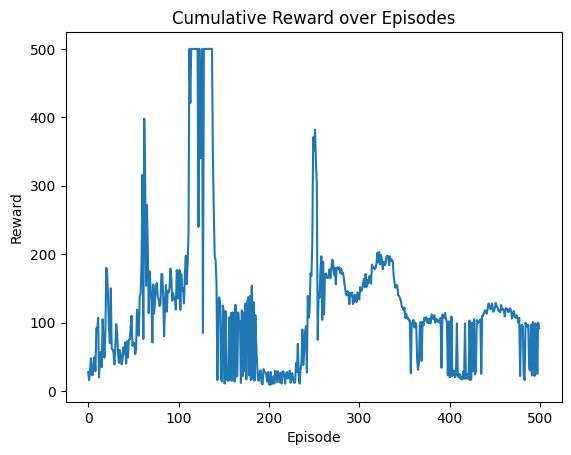

In [44]:
plot_rewards(episode_rewards)

##### **Q24: How do you compare the agent’s performance when using a policy gradient method to other reinforcement learning methods?**

In [45]:
# train and evaluate another agent (e.g., DQN) separately and compare average rewards
# example comparison (placeholder, assuming dqn_rewards are collected similarly):
# plt.plot(episode_rewards, label='Policy Gradient')
# plt.plot(dqn_rewards, label='DQN')
# plt.xlabel('Episode')
# plt.ylabel('Reward')
# plt.legend()
# plt.title('Comparison between Policy Gradient and DQN')
# plt.show()

## Experimenting with hyperparameters


##### **Q25: How do you experiment with different learning rates to observe their impact on the agent’s learning speed and convergence?**


In [46]:
learning_rates = [1e-3, 1e-2, 1e-1]
lr_rewards = {}

for lr in learning_rates:
    policy = PolicyNetwork(state_dim, action_dim).to(device)
    policy.initialize_weights()
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    rewards = train(env, policy, optimizer, episodes=300, gamma=0.99)
    lr_rewards[lr] = rewards

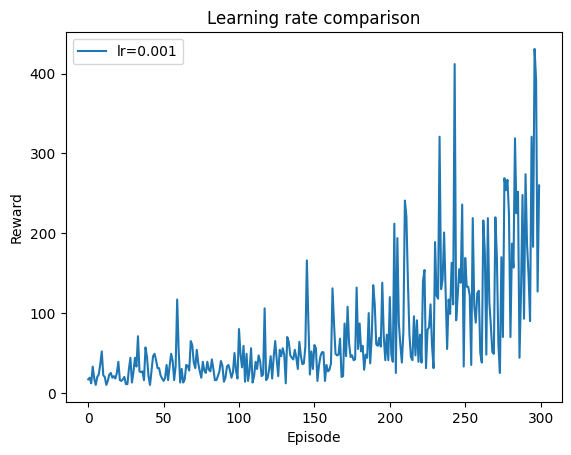

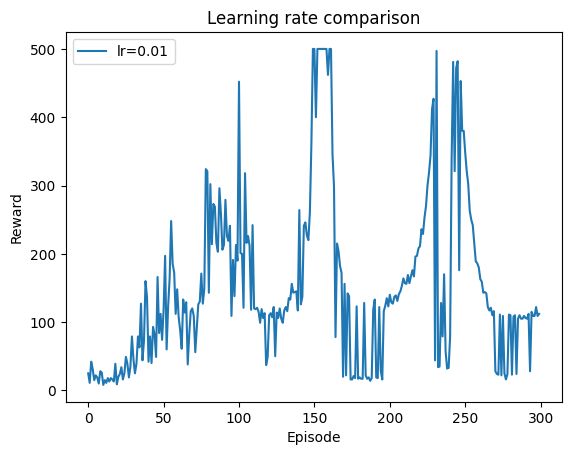

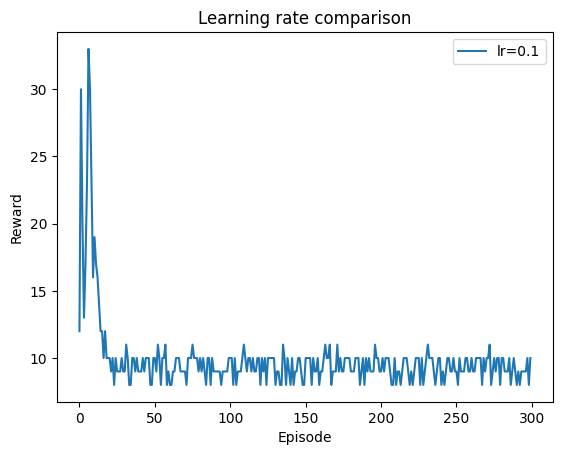

In [47]:
for lr, rewards in lr_rewards.items():
    plt.plot(rewards, label=f'lr={lr}')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.title('Learning rate comparison')
    plt.show()

##### **Q26: How do you adjust the discount factor (gamma) to analyze how it affects the agent’s long-term planning and reward optimization?**


In [48]:
gammas = [0.90, 0.95, 0.99]
gamma_rewards = {}

for gamma in gammas:
    policy = PolicyNetwork(state_dim, action_dim).to(device)
    policy.initialize_weights()
    optimizer = optim.Adam(policy.parameters(), lr=1e-2)
    rewards = train(env, policy, optimizer, episodes=300, gamma=gamma)
    gamma_rewards[gamma] = rewards

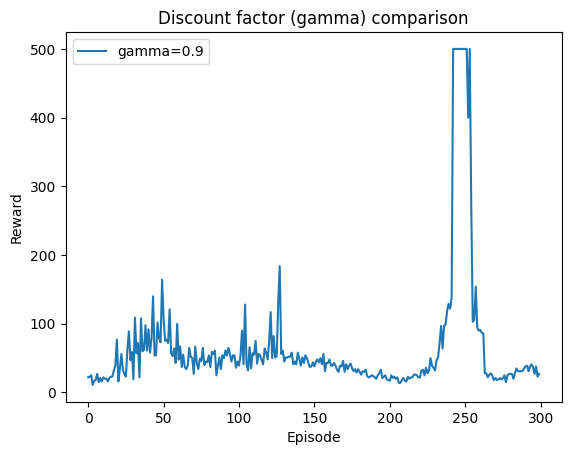

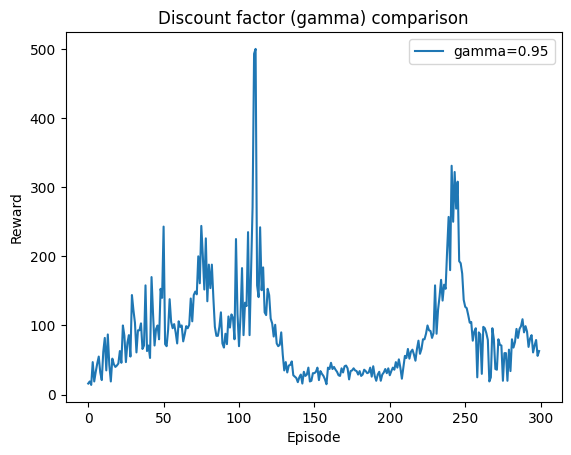

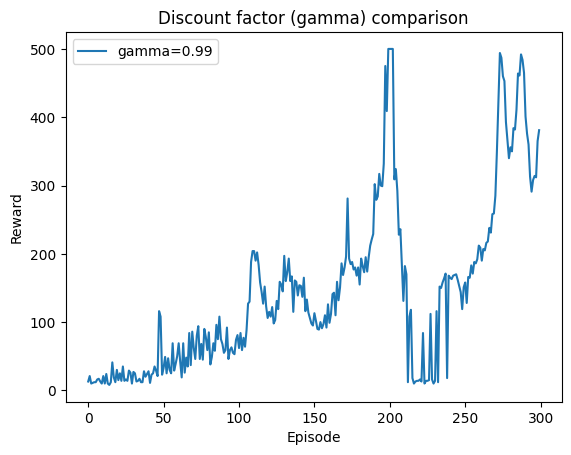

In [49]:
for gamma, rewards in gamma_rewards.items():
    plt.plot(rewards, label=f'gamma={gamma}')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.title('Discount factor (gamma) comparison')
    plt.show()

##### **Q27: How do you experiment with different policy network architectures, such as adding more layers or units, and analyze the effect on performance?**


In [50]:
class PolicyNetworkDeep(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetworkDeep, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=-1)
        return x

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def select_action(self, state):
        probs = self.forward(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob

In [51]:
policy = PolicyNetworkDeep(state_dim, action_dim).to(device)
policy.initialize_weights()
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
episode_rewards_deep = train(env, policy, optimizer, episodes=500, gamma=0.99)

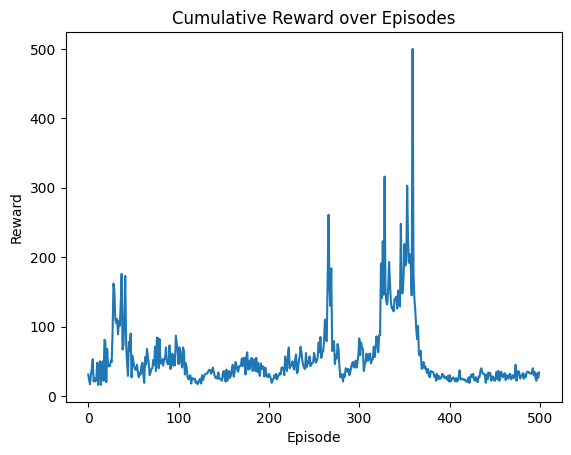

In [52]:
plot_rewards(episode_rewards_deep)

##### **Q28: How do you experiment with different batch sizes for updating the policy and observe their impact on training stability?**


In [53]:
def train_batch(env, policy, optimizer, episodes, gamma, batch_size):
    episode_rewards = []
    batch_log_probs = []
    batch_rewards = []
    for episode in range(episodes):
        log_probs, rewards = collect_episode(env, policy)
        batch_log_probs.extend(log_probs)
        batch_rewards.extend(rewards)
        episode_rewards.append(sum(rewards))

        if (episode + 1) % batch_size == 0:
            loss = compute_loss(batch_log_probs, batch_rewards, gamma)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_log_probs = []
            batch_rewards = []
    return episode_rewards

In [54]:
policy = PolicyNetwork(state_dim, action_dim).to(device)
policy.initialize_weights()
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
batch_rewards_5 = train_batch(env, policy, optimizer, episodes=500, gamma=0.99, batch_size=5)
batch_rewards_10 = train_batch(env, policy, optimizer, episodes=500, gamma=0.99, batch_size=10)

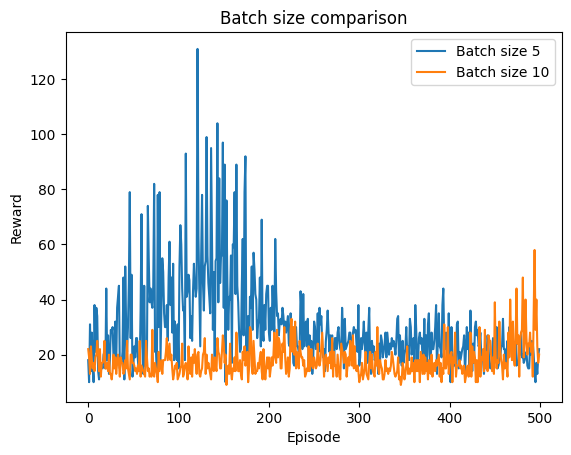

In [55]:
plt.plot(batch_rewards_5, label='Batch size 5')
plt.plot(batch_rewards_10, label='Batch size 10')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.title('Batch size comparison')
plt.show()

##### **Q29: How do you experiment with different methods of reward normalization to improve the stability of the policy gradient updates?**


In [56]:
def normalize_returns(returns):
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    return returns

def compute_loss_normalized(log_probs, rewards, gamma):
    returns = compute_returns(rewards, gamma)
    returns = normalize_returns(returns)
    loss = compute_policy_gradient(log_probs, returns)
    return loss

def train_normalized(env, policy, optimizer, episodes, gamma):
    episode_rewards = []
    for episode in range(episodes):
        log_probs, rewards = collect_episode(env, policy)
        loss = compute_loss_normalized(log_probs, rewards, gamma)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        episode_rewards.append(sum(rewards))
    return episode_rewards

In [57]:
policy = PolicyNetwork(state_dim, action_dim).to(device)
policy.initialize_weights()
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
normalized_rewards = train_normalized(env, policy, optimizer, episodes=500, gamma=0.99)

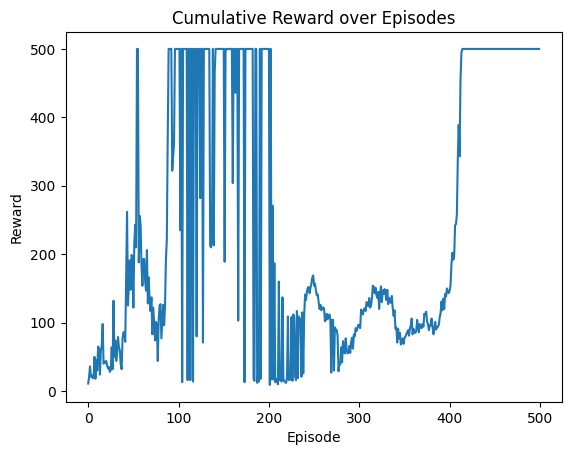

In [58]:
plot_rewards(normalized_rewards)

##### **Q30: How do you implement and evaluate an entropy bonus to encourage exploration during training and avoid premature convergence?**

In [59]:
def compute_loss_with_entropy(log_probs, rewards, gamma, entropy_coeff=0.01):
    returns = compute_returns(rewards, gamma)
    entropy = -torch.stack([log_prob.exp() * log_prob for log_prob in log_probs]).sum()
    policy_gradient = compute_policy_gradient(log_probs, returns)
    loss = policy_gradient - entropy_coeff * entropy
    return loss

def train_entropy(env, policy, optimizer, episodes, gamma, entropy_coeff):
    episode_rewards = []
    for episode in range(episodes):
        log_probs, rewards = collect_episode(env, policy)
        loss = compute_loss_with_entropy(log_probs, rewards, gamma, entropy_coeff)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        episode_rewards.append(sum(rewards))
    return episode_rewards

In [60]:
policy = PolicyNetwork(state_dim, action_dim).to(device)
policy.initialize_weights()
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
entropy_rewards = train_entropy(env, policy, optimizer, episodes=500, gamma=0.99, entropy_coeff=0.01)

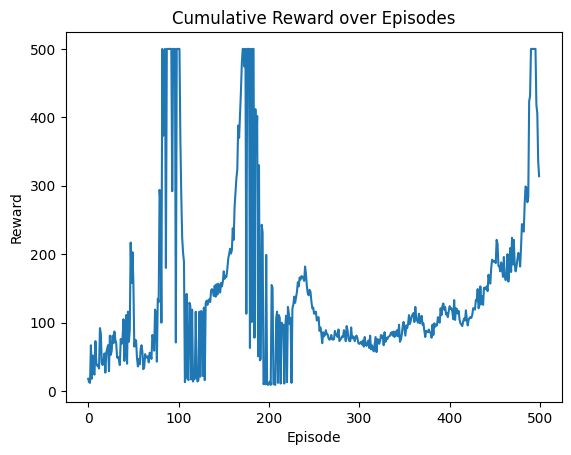

In [61]:
plot_rewards(entropy_rewards)